# GRN Evaluation Notebook

## Prerequisites

This notebook requires an inferred GRN saved as a CSV file named `inferred_grn.csv` in the same directory.

**CSV Format Requirements:**
- The CSV should have gene names as both row index (first column) and column headers
- Values should be continuous scores (e.g., attention weights)
- Shape: `[n_genes × n_genes]` where n_genes matches the ground truth network
- Example structure:
  ```
   ... ,Gene1,Gene2,Gene3, ...
  Gene1, 0.1 , 0.8 , 0.3 , ...
  Gene2, 0.2 , 0.1 , 0.9 , ...
  Gene3, 0.7 , 0.4 , 0.2 , ...
   ...
  ```

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, ConfusionMatrixDisplay

# Import your dataloader
from dataloader import BEELINEDataset

## Load Ground Truth Data

In [13]:
# Load BEELINE dataset for ground truth
print("Loading BEELINE dataset for ground truth...")
dataset = BEELINEDataset(
    base_dir='/home/asp/Downloads/HeaDS/GRN Inference/data/BEELINE',
    category='Curated',
    dataset_name='GSD',
    variant='2000-1'
)

# Get ground truth adjacency matrix
data_dict = dataset.get_full_data()
true_adjacency = data_dict['adjacency'].numpy()  # [n_genes, n_genes]
gene_names = data_dict['gene_names']

print(f"Dataset: {dataset.dataset_name}-{dataset.variant}")
print(f"True adjacency shape: {true_adjacency.shape}")
print(f"True GRN edges: {(true_adjacency != 0).sum()}")
print(f"Number of genes: {len(gene_names)}")

Loading BEELINE dataset for ground truth...
Dataset: GSD-2000-1
True adjacency shape: (19, 19)
True GRN edges: 79
Number of genes: 19


## Load Inferred GRN

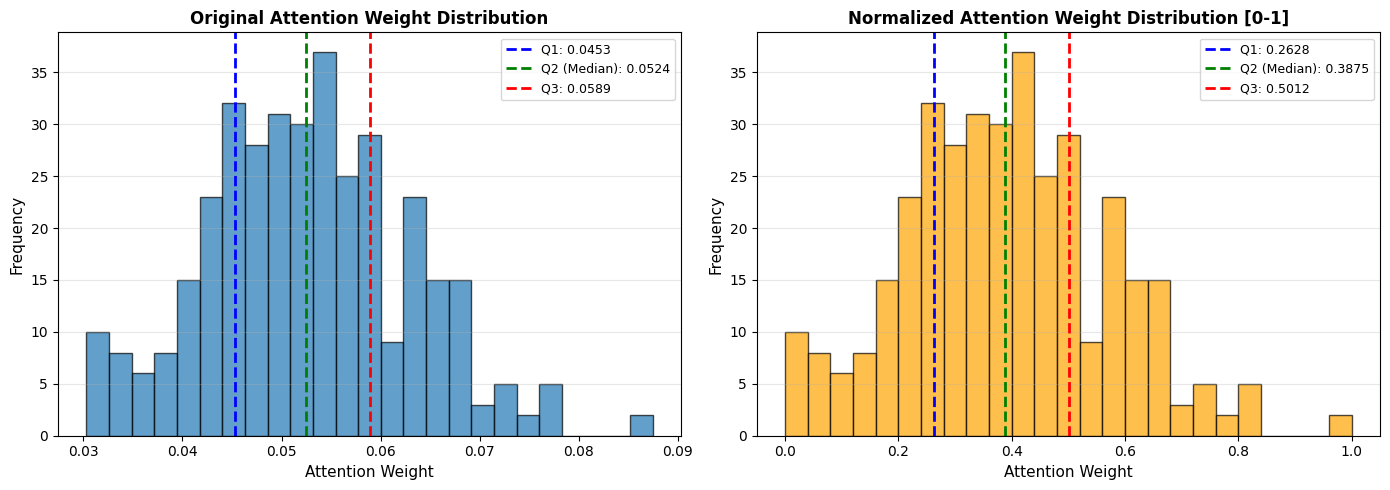


Distribution Statistics (Original):
  Mean: 0.0526
  Median (Q2): 0.0524
  Q1 (25th percentile): 0.0453
  Q3 (75th percentile): 0.0589
  Std Dev: 0.0103
  Min: 0.0303
  Max: 0.0875

Distribution Statistics (Normalized):
  Mean: 0.3908
  Median (Q2): 0.3875
  Q1 (25th percentile): 0.2628
  Q3 (75th percentile): 0.5012
  Std Dev: 0.1803
  Min: 0.0000
  Max: 1.0000
  Edges > Q3: 90 (24.93%)


In [14]:
# Load inferred GRN from saved file
inferred_grn_df = pd.read_csv('inferred_grn.csv', index_col=0)
inferred_grn = inferred_grn_df.values

# Normalize inferred GRN to [0, 1] range for fair comparison
inferred_grn_min = inferred_grn.min()
inferred_grn_max = inferred_grn.max()
if inferred_grn_max > inferred_grn_min:
    inferred_grn = (inferred_grn - inferred_grn_min) / (inferred_grn_max - inferred_grn_min)
else:
    inferred_grn = np.zeros_like(inferred_grn)

# Verify dimensions match
assert inferred_grn.shape[0] == len(gene_names), f"Shape mismatch! GRN: {inferred_grn.shape[0]}, genes: {len(gene_names)}"

# Visualize attention weight distribution - side by side histograms
inferred_grn_original = inferred_grn_df.values

# Calculate quartiles for both distributions
q1_orig = np.percentile(inferred_grn_original, 25)
q2_orig = np.percentile(inferred_grn_original, 50)
q3_orig = np.percentile(inferred_grn_original, 75)

q1_norm = np.percentile(inferred_grn, 25)
q2_norm = np.percentile(inferred_grn, 50)
q3_norm = np.percentile(inferred_grn, 75)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original (unnormalized) attention weights - Histogram
axes[0].hist(inferred_grn_original.flatten(), bins=25, edgecolor='black', alpha=0.7)
axes[0].axvline(x=q1_orig, color='blue', linestyle='--', linewidth=2, label=f'Q1: {q1_orig:.4f}')
axes[0].axvline(x=q2_orig, color='green', linestyle='--', linewidth=2, label=f'Q2 (Median): {q2_orig:.4f}')
axes[0].axvline(x=q3_orig, color='red', linestyle='--', linewidth=2, label=f'Q3: {q3_orig:.4f}')
axes[0].set_xlabel('Attention Weight', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Original Attention Weight Distribution', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].legend(fontsize=9)

# Normalized attention weights - Histogram
axes[1].hist(inferred_grn.flatten(), bins=25, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(x=q1_norm, color='blue', linestyle='--', linewidth=2, label=f'Q1: {q1_norm:.4f}')
axes[1].axvline(x=q2_norm, color='green', linestyle='--', linewidth=2, label=f'Q2 (Median): {q2_norm:.4f}')
axes[1].axvline(x=q3_norm, color='red', linestyle='--', linewidth=2, label=f'Q3: {q3_norm:.4f}')
axes[1].set_xlabel('Attention Weight', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Normalized Attention Weight Distribution [0-1]', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nDistribution Statistics (Original):")
print(f"  Mean: {inferred_grn_original.mean():.4f}")
print(f"  Median (Q2): {q2_orig:.4f}")
print(f"  Q1 (25th percentile): {q1_orig:.4f}")
print(f"  Q3 (75th percentile): {q3_orig:.4f}")
print(f"  Std Dev: {inferred_grn_original.std():.4f}")
print(f"  Min: {inferred_grn_original.min():.4f}")
print(f"  Max: {inferred_grn_original.max():.4f}")

print(f"\nDistribution Statistics (Normalized):")
print(f"  Mean: {inferred_grn.mean():.4f}")
print(f"  Median (Q2): {q2_norm:.4f}")
print(f"  Q1 (25th percentile): {q1_norm:.4f}")
print(f"  Q3 (75th percentile): {q3_norm:.4f}")
print(f"  Std Dev: {inferred_grn.std():.4f}")
print(f"  Min: {inferred_grn.min():.4f}")
print(f"  Max: {inferred_grn.max():.4f}")
print(f"  Edges > Q3: {(inferred_grn > q3_norm).sum()} ({(inferred_grn > q3_norm).sum() / inferred_grn.size * 100:.2f}%)")

## AUPRC (Area Under Precision-Recall Curve)

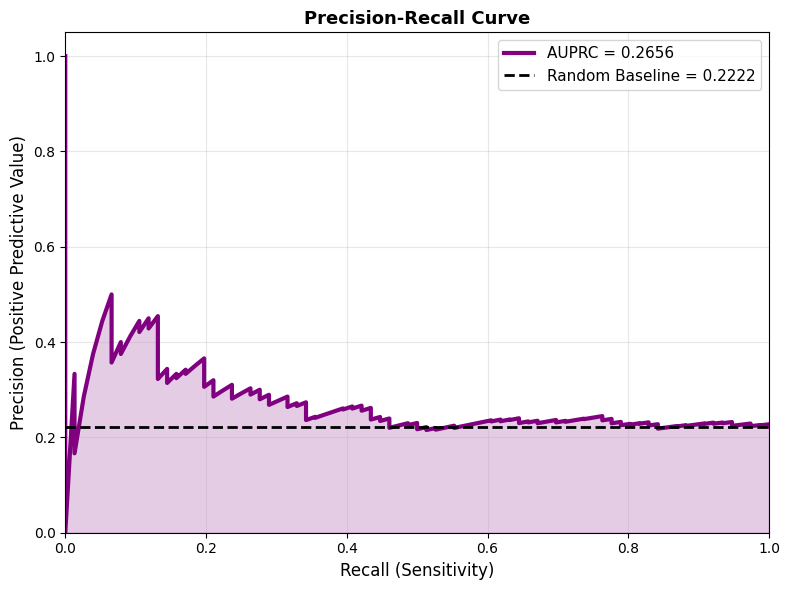

In [15]:
from sklearn.metrics import precision_recall_curve, auc

# Flatten matrices and remove diagonal (self-loops)
n_genes = inferred_grn.shape[0]
mask = ~np.eye(n_genes, dtype=bool)

y_true_flat = (np.abs(true_adjacency[mask]) > 0).astype(int)
y_pred_flat = inferred_grn[mask]

# Calculate Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_true_flat, y_pred_flat)
auprc = auc(recall, precision)

# Random baseline for comparison
baseline = y_true_flat.sum() / len(y_true_flat)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(recall, precision, color='purple', lw=3, label=f'AUPRC = {auprc:.4f}')
ax.plot([0, 1], [baseline, baseline], 'k--', lw=2, label=f'Random Baseline = {baseline:.4f}')
ax.fill_between(recall, precision, alpha=0.2, color='purple')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall (Sensitivity)', fontsize=12)
ax.set_ylabel('Precision (Positive Predictive Value)', fontsize=12)
ax.set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
ax.legend(loc="upper right", fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Precision @ k (Top-k Predictions)

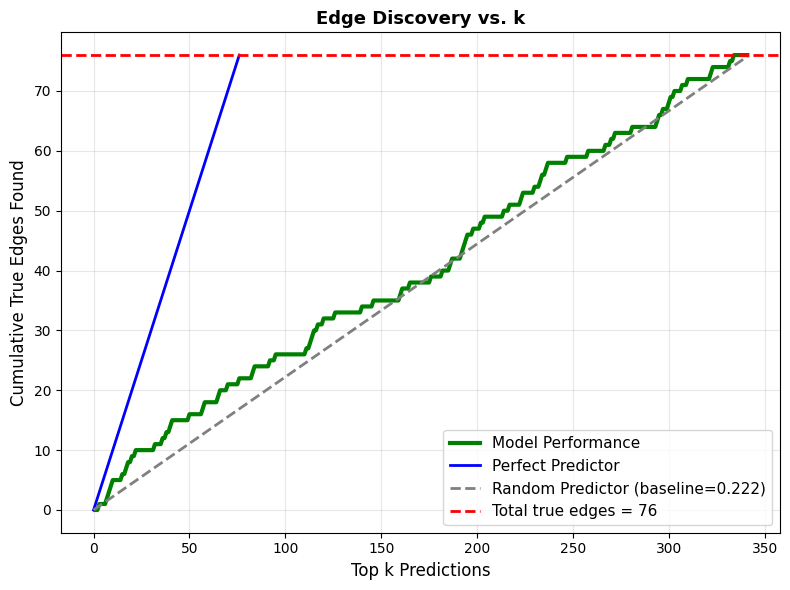

In [16]:
k_values = [10, 20, 50, 100, 200]
precisions_at_k = {}

# Sort predictions in descending order
sorted_indices = np.argsort(y_pred_flat)[::-1]


for k in k_values:
    if k > len(y_pred_flat):
        continue
    
    top_k_indices = sorted_indices[:k]
    hits = y_true_flat[top_k_indices].sum()
    precision_k = hits / k
    precisions_at_k[k] = precision_k

# Visualize Precision @ k - Cumulative edge discovery
cumulative_hits = []
for k in range(1, min(501, len(y_pred_flat))):
    top_k_indices = sorted_indices[:k]
    hits = y_true_flat[top_k_indices].sum()
    cumulative_hits.append(hits)

total_true_edges = int(y_true_flat.sum())
random_baseline_rate = baseline  # Proportion of true edges in dataset

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot actual performance
ax.plot(range(1, len(cumulative_hits)+1), cumulative_hits, color='green', lw=3, label='Model Performance')

# Plot perfect predictor line (0,0 to total_edges, total_edges)
ax.plot([0, total_true_edges], [0, total_true_edges], color='blue', linestyle='-', linewidth=2, 
        label=f'Perfect Predictor')

# Plot random predictor line (expected value: k * baseline)
k_range = np.array(range(0, len(cumulative_hits)+1))
random_expected = k_range * random_baseline_rate
ax.plot(k_range, random_expected, color='gray', linestyle='--', linewidth=2, 
        label=f'Random Predictor (baseline={baseline:.3f})')

# Plot total edges line
ax.axhline(y=total_true_edges, color='red', linestyle='--', linewidth=2, 
           label=f'Total true edges = {total_true_edges}')

ax.set_xlabel('Top k Predictions', fontsize=12)
ax.set_ylabel('Cumulative True Edges Found', fontsize=12)
ax.set_title('Edge Discovery vs. k', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## AUROC (Area Under ROC Curve)


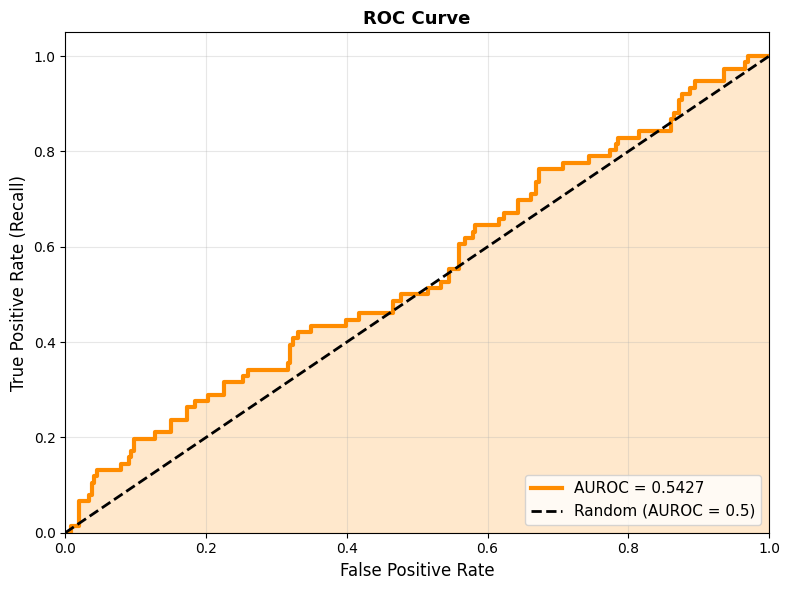

In [17]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_true_flat, y_pred_flat)
auroc = auc(fpr, tpr)

# Plot ROC Curve
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(fpr, tpr, color='darkorange', lw=3, label=f'AUROC = {auroc:.4f}')
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUROC = 0.5)')
ax.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12)
ax.set_title('ROC Curve', fontsize=13, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()



Analyzing attention patterns for all 19 genes
✓ Green = Activator (+), Red = Inhibitor (-), Gray = No true edge
✓ Green = Activator (+), Red = Inhibitor (-), Gray = No true edge


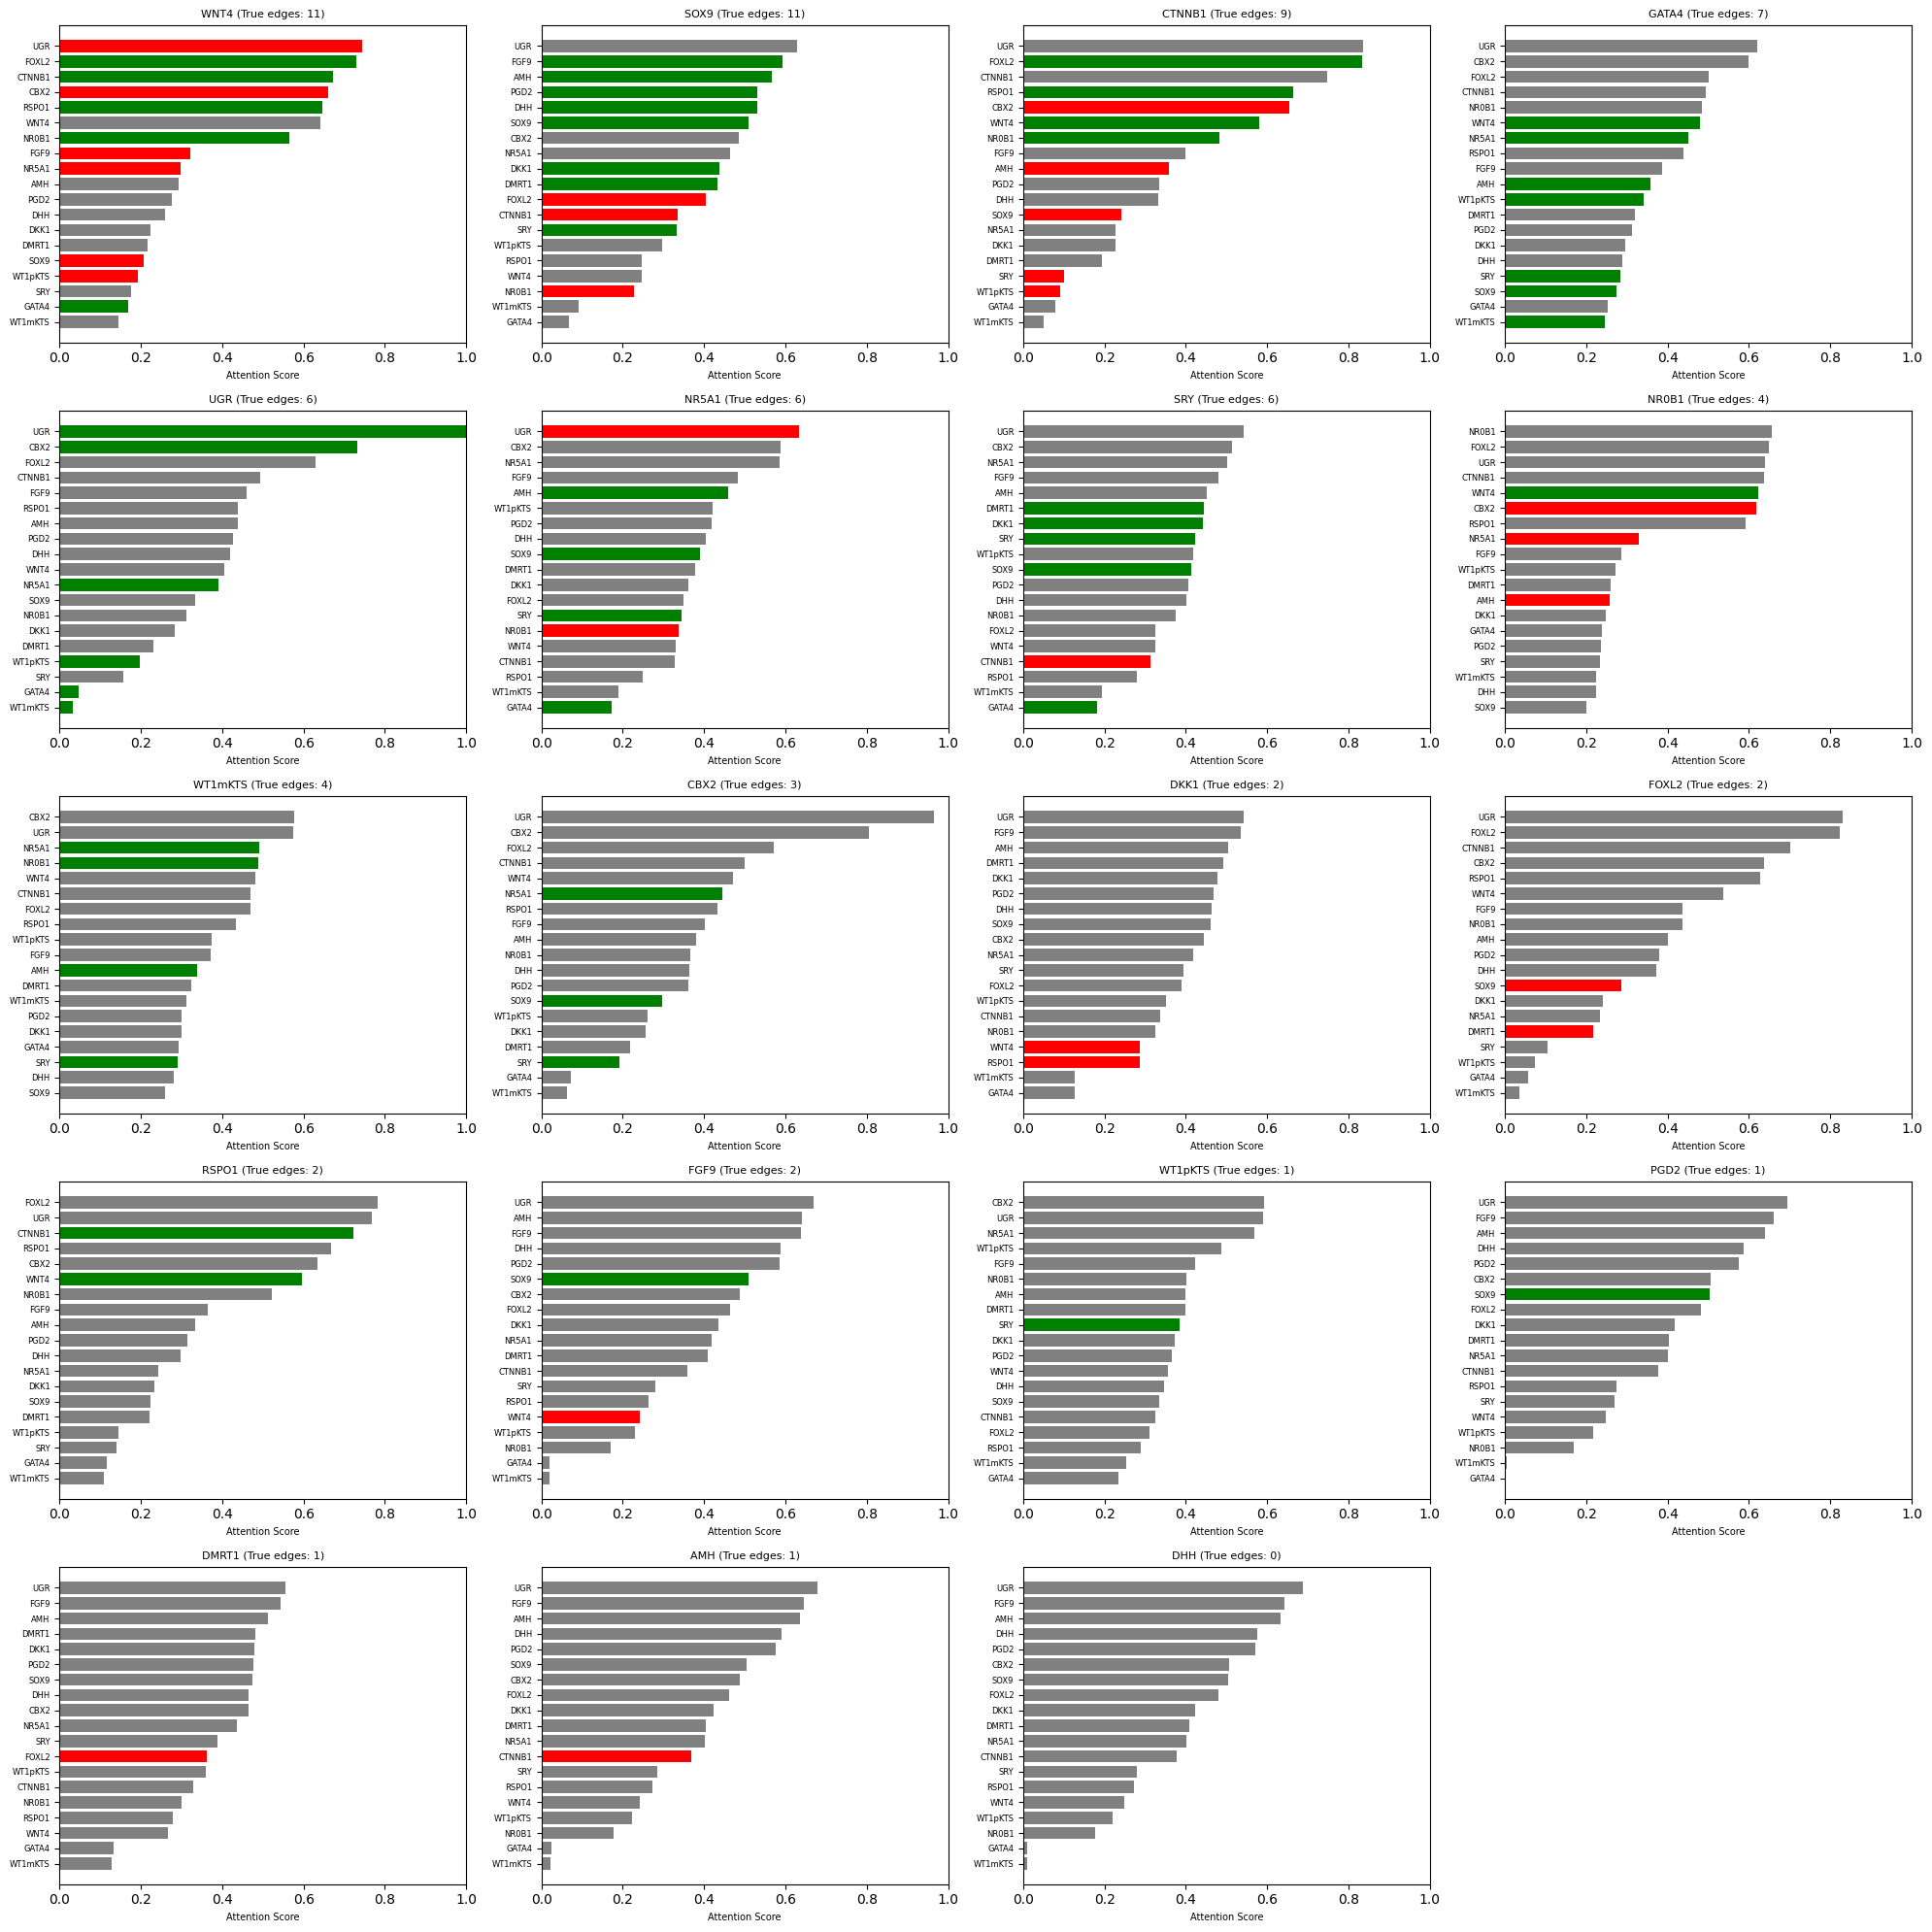

In [18]:
# Analyze attention patterns for all genes
print("\n" + "=" * 60)
print(f"Analyzing attention patterns for all {len(gene_names)} genes")
print("=" * 60)

# Count outgoing edges for each gene in ground truth
true_out_degree = (np.abs(true_adjacency) > 0).sum(axis=1)

# Sort genes by true edge count (descending)
sorted_gene_indices = np.argsort(true_out_degree)[::-1]

# Get their attention patterns - 5 rows x 4 columns for 19 genes
n_rows = int(np.ceil(len(gene_names) / 4))
fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, gene_idx in enumerate(sorted_gene_indices):
    gene_name = gene_names[gene_idx]
    
    # Attention from this gene to all others
    attention_from = inferred_grn[gene_idx, :]
    
    # Top regulators by attention (max 19 since we only have 19 genes)
    n_top = min(19, len(gene_names))
    top_regulators_idx = np.argsort(attention_from)[-n_top:][::-1]  # Reverse to get highest first
    top_regulators = [gene_names[j] for j in top_regulators_idx]
    top_scores = attention_from[top_regulators_idx]
    
    # Check which are true edges and their type
    colors = []
    for j in top_regulators_idx:
        edge_weight = true_adjacency[gene_idx, j]
        if edge_weight > 0:
            colors.append('green')  # Activator/regulator
        elif edge_weight < 0:
            colors.append('red')    # Inhibitor
        else:
            colors.append('gray')   # No true edge
    
    axes[i].barh(range(n_top), top_scores, color=colors)
    axes[i].set_yticks(range(n_top))
    axes[i].set_yticklabels(top_regulators, fontsize=6)
    axes[i].set_xlabel('Attention Score', fontsize=7)
    axes[i].set_title(f'{gene_name} (True edges: {true_out_degree[gene_idx]})', fontsize=8)
    axes[i].set_xlim(0, 1)  # Force x-axis from 0 to 1
    axes[i].invert_yaxis()

# Hide any unused subplots
for i in range(len(gene_names), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
print("✓ Green = Activator (+), Red = Inhibitor (-), Gray = No true edge")
plt.show()

## Visualize GRN Heatmaps

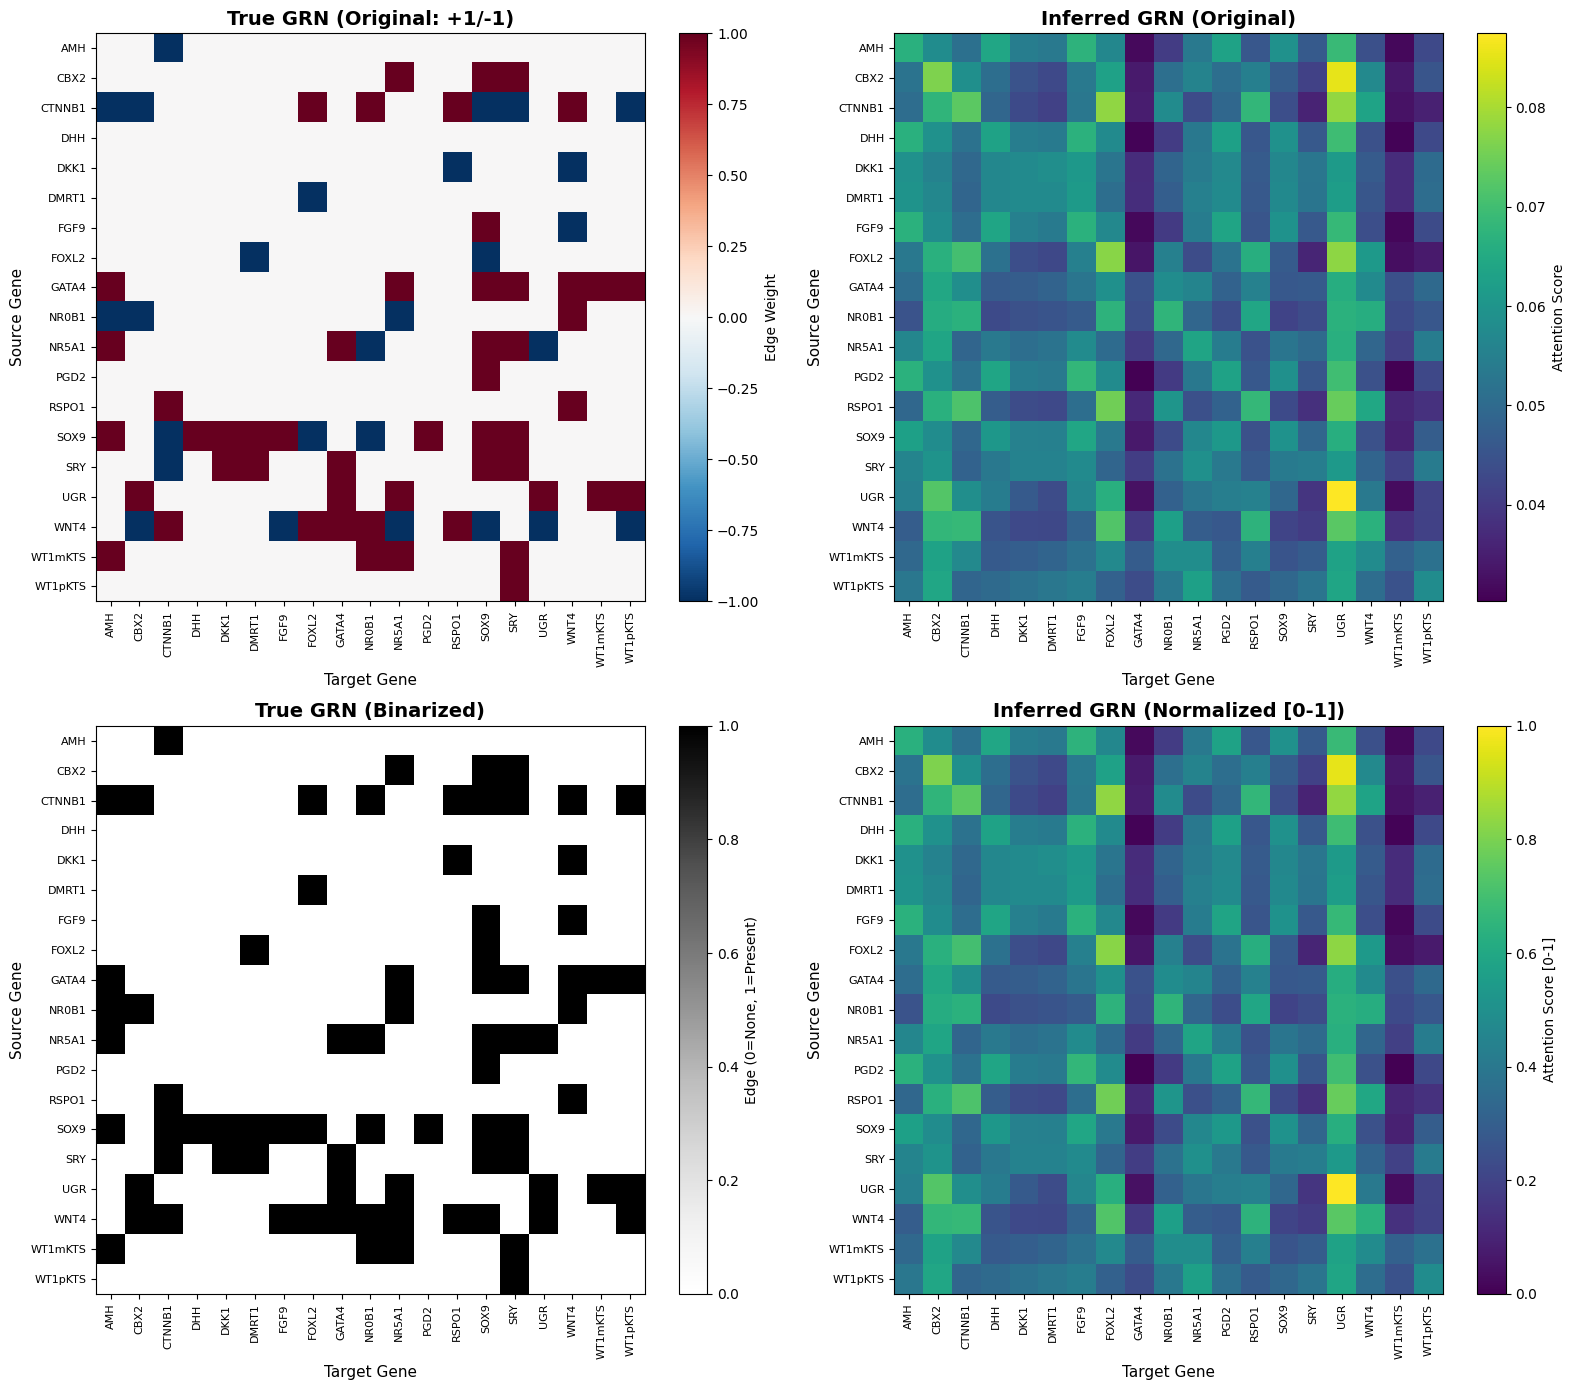

In [19]:
# Load original (non-normalized) inferred GRN for visualization
inferred_grn_original = np.load('inferred_grn.npy')

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Top-left: True GRN (original with +1/-1)
im1 = axes[0, 0].imshow(true_adjacency, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
axes[0, 0].set_title('True GRN (Original: +1/-1)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Target Gene', fontsize=11)
axes[0, 0].set_ylabel('Source Gene', fontsize=11)
axes[0, 0].set_xticks(range(len(gene_names)))
axes[0, 0].set_yticks(range(len(gene_names)))
axes[0, 0].set_xticklabels(gene_names, rotation=90, fontsize=8)
axes[0, 0].set_yticklabels(gene_names, fontsize=8)
plt.colorbar(im1, ax=axes[0, 0], label='Edge Weight')

# Bottom-left: True GRN (binarized)
true_binary_viz = (np.abs(true_adjacency) > 0).astype(float)
im2 = axes[1, 0].imshow(true_binary_viz, cmap='Greys', vmin=0, vmax=1, aspect='auto')
axes[1, 0].set_title('True GRN (Binarized)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Target Gene', fontsize=11)
axes[1, 0].set_ylabel('Source Gene', fontsize=11)
axes[1, 0].set_xticks(range(len(gene_names)))
axes[1, 0].set_yticks(range(len(gene_names)))
axes[1, 0].set_xticklabels(gene_names, rotation=90, fontsize=8)
axes[1, 0].set_yticklabels(gene_names, fontsize=8)
plt.colorbar(im2, ax=axes[1, 0], label='Edge (0=None, 1=Present)')

# Top-right: Inferred GRN (original)
im3 = axes[0, 1].imshow(inferred_grn_original, cmap='viridis', aspect='auto')
axes[0, 1].set_title('Inferred GRN (Original)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Target Gene', fontsize=11)
axes[0, 1].set_ylabel('Source Gene', fontsize=11)
axes[0, 1].set_xticks(range(len(gene_names)))
axes[0, 1].set_yticks(range(len(gene_names)))
axes[0, 1].set_xticklabels(gene_names, rotation=90, fontsize=8)
axes[0, 1].set_yticklabels(gene_names, fontsize=8)
plt.colorbar(im3, ax=axes[0, 1], label='Attention Score')

# Bottom-right: Inferred GRN (normalized)
im4 = axes[1, 1].imshow(inferred_grn, cmap='viridis', vmin=0, vmax=1, aspect='auto')
axes[1, 1].set_title('Inferred GRN (Normalized [0-1])', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Target Gene', fontsize=11)
axes[1, 1].set_ylabel('Source Gene', fontsize=11)
axes[1, 1].set_xticks(range(len(gene_names)))
axes[1, 1].set_yticks(range(len(gene_names)))
axes[1, 1].set_xticklabels(gene_names, rotation=90, fontsize=8)
axes[1, 1].set_yticklabels(gene_names, fontsize=8)
plt.colorbar(im4, ax=axes[1, 1], label='Attention Score [0-1]')

plt.tight_layout()
plt.show()

Number of true edges: 79
Threshold for top 79 edges: 0.5212

Confusion Matrix Statistics:
  True Positive (correctly predicted interaction): 21
  True Negative (correctly predicted no interaction): 224
  False Positive (incorrectly predicted interaction): 58
  False Negative (incorrectly predicted no interaction): 58

  Precision: 0.2658
  Recall: 0.2658
  Accuracy: 0.6787


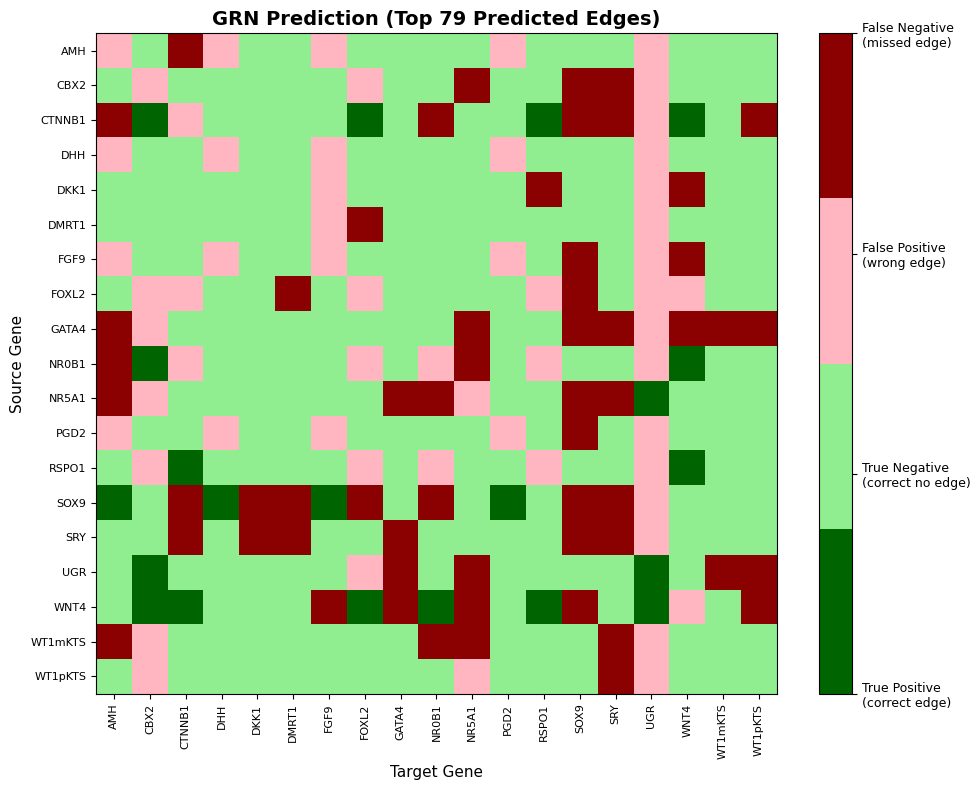

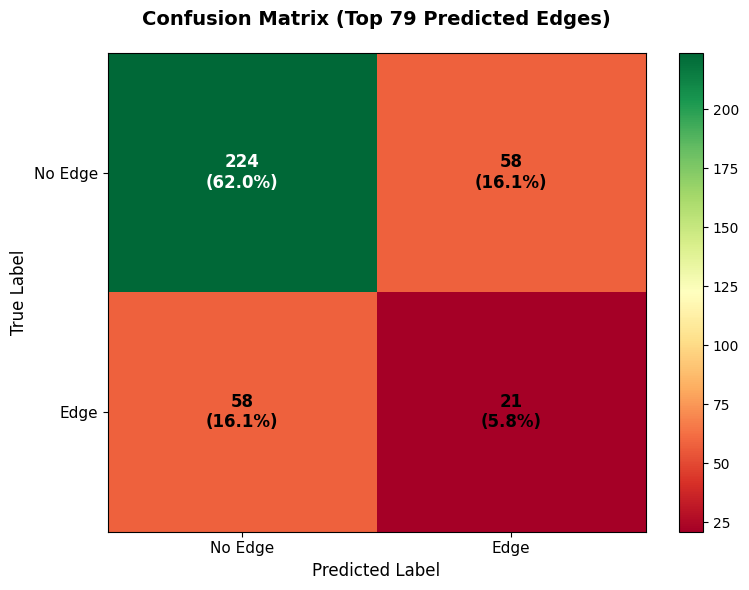

In [20]:
# Number of true edges
n_true_edges = (true_adjacency != 0).sum()
print(f"Number of true edges: {n_true_edges}")

# Get top N edges from inferred GRN (where N = number of true edges)
inferred_flat = inferred_grn.flatten()
threshold_idx = len(inferred_flat) - n_true_edges
threshold = np.sort(inferred_flat)[threshold_idx]

print(f"Threshold for top {n_true_edges} edges: {threshold:.4f}")

# Create confusion matrix visualization
inferred_binary = (inferred_grn >= threshold).astype(float)
true_binary = (np.abs(true_adjacency) > 0).astype(float)

# Confusion matrix encoding:
# 0 = True Positive (correctly predicted interaction) - dark green
# 1 = True Negative (correctly predicted no interaction) - light green
# 2 = False Positive (incorrectly predicted interaction) - light red
# 3 = False Negative (incorrectly predicted no interaction) - dark red
confusion = np.zeros_like(true_binary)

# True Positive: true edge AND predicted edge
confusion[(true_binary == 1) & (inferred_binary == 1)] = 0

# True Negative: no true edge AND no predicted edge
confusion[(true_binary == 0) & (inferred_binary == 0)] = 1

# False Positive: no true edge BUT predicted edge
confusion[(true_binary == 0) & (inferred_binary == 1)] = 2

# False Negative: true edge BUT no predicted edge
confusion[(true_binary == 1) & (inferred_binary == 0)] = 3

# Count statistics
true_positive = (confusion == 0).sum()
true_negative = (confusion == 1).sum()
false_positive = (confusion == 2).sum()
false_negative = (confusion == 3).sum()

print(f"\nConfusion Matrix Statistics:")
print(f"  True Positive (correctly predicted interaction): {true_positive}")
print(f"  True Negative (correctly predicted no interaction): {true_negative}")
print(f"  False Positive (incorrectly predicted interaction): {false_positive}")
print(f"  False Negative (incorrectly predicted no interaction): {false_negative}")
print(f"\n  Precision: {true_positive / (true_positive + false_positive):.4f}")
print(f"  Recall: {true_positive / (true_positive + false_negative):.4f}")
print(f"  Accuracy: {(true_positive + true_negative) / confusion.size:.4f}")

# Visualize with custom colors
from matplotlib.colors import ListedColormap

# Colors: dark green (TP), light green (TN), light red (FP), dark red (FN)
colors = ['#006400', '#90EE90', '#FFB6C1', '#8B0000']
cmap = ListedColormap(colors)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

im = ax.imshow(confusion, cmap=cmap, vmin=0, vmax=3, aspect='auto')
ax.set_title(f'GRN Prediction (Top {n_true_edges} Predicted Edges)', 
                fontsize=14, fontweight='bold')
ax.set_xlabel('Target Gene', fontsize=11)
ax.set_ylabel('Source Gene', fontsize=11)
ax.set_xticks(range(len(gene_names)))
ax.set_yticks(range(len(gene_names)))
ax.set_xticklabels(gene_names, rotation=90, fontsize=8)
ax.set_yticklabels(gene_names, fontsize=8)

cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels([
    'True Positive\n(correct edge)',
    'True Negative\n(correct no edge)',
    'False Positive\n(wrong edge)',
    'False Negative\n(missed edge)'
], fontsize=9)

plt.tight_layout()
plt.show()

# Create confusion matrix summary with percentages
conf_matrix_2x2 = np.array([
    [true_negative, false_positive],
    [false_negative, true_positive]
])

# Calculate percentages
total = conf_matrix_2x2.sum()
conf_matrix_pct = (conf_matrix_2x2 / total * 100)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot with percentage annotations
im = ax.imshow(conf_matrix_2x2, cmap='RdYlGn', aspect='auto')

# Add percentage text
for i in range(2):
    for j in range(2):
        text_color = 'white' if conf_matrix_2x2[i, j] > conf_matrix_2x2.max() / 2 else 'black'
        ax.text(j, i, f'{conf_matrix_2x2[i, j]}\n({conf_matrix_pct[i, j]:.1f}%)',
                ha='center', va='center', color=text_color, fontsize=12, fontweight='bold')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['No Edge', 'Edge'], fontsize=11)
ax.set_yticklabels(['No Edge', 'Edge'], fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title(f'Confusion Matrix (Top {n_true_edges} Predicted Edges)', 
                fontsize=14, fontweight='bold', pad=20)

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

Using Q3 (upper quartile) threshold: 0.5012

Confusion Matrix Statistics (Q3 threshold):
  True Positive: 24
  True Negative: 215
  False Positive: 67
  False Negative: 55

  Precision: 0.2637
  Recall: 0.3038
  Accuracy: 0.6620


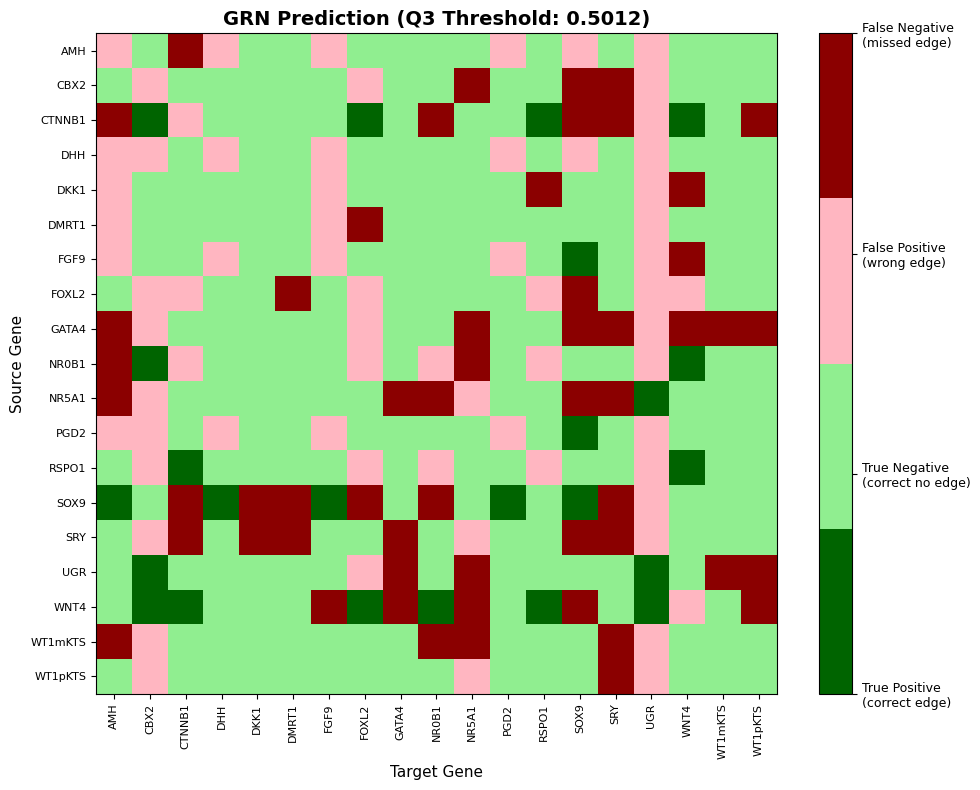

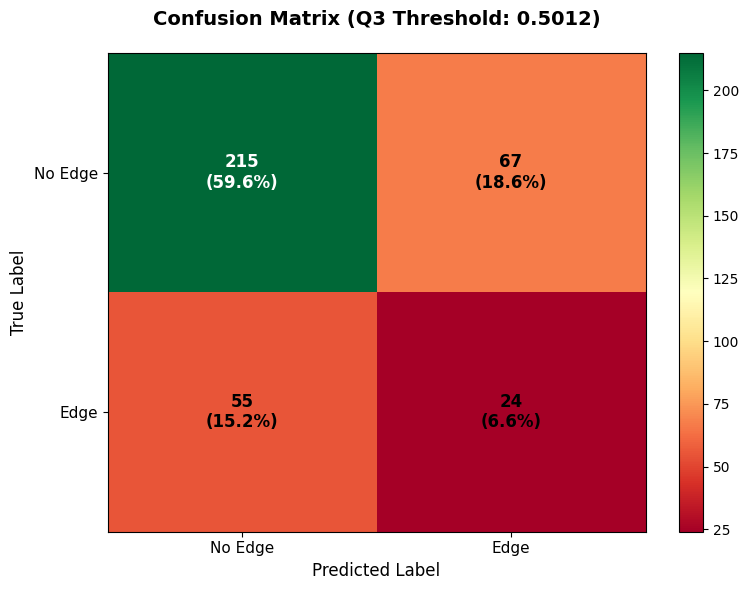

In [21]:
# Use Q3 (upper quartile) threshold for predictions
threshold_q3 = np.percentile(inferred_grn, 75)
print(f"Using Q3 (upper quartile) threshold: {threshold_q3:.4f}")

# Create confusion matrix visualization with Q3 threshold
inferred_binary_q3 = (inferred_grn >= threshold_q3).astype(float)
true_binary = (np.abs(true_adjacency) > 0).astype(float)

# Confusion matrix encoding (same as before)
confusion_q3 = np.zeros_like(true_binary)
confusion_q3[(true_binary == 1) & (inferred_binary_q3 == 1)] = 0  # TP - dark green
confusion_q3[(true_binary == 0) & (inferred_binary_q3 == 0)] = 1  # TN - light green
confusion_q3[(true_binary == 0) & (inferred_binary_q3 == 1)] = 2  # FP - light red
confusion_q3[(true_binary == 1) & (inferred_binary_q3 == 0)] = 3  # FN - dark red

# Count statistics
tp_q3 = (confusion_q3 == 0).sum()
tn_q3 = (confusion_q3 == 1).sum()
fp_q3 = (confusion_q3 == 2).sum()
fn_q3 = (confusion_q3 == 3).sum()

print(f"\nConfusion Matrix Statistics (Q3 threshold):")
print(f"  True Positive: {tp_q3}")
print(f"  True Negative: {tn_q3}")
print(f"  False Positive: {fp_q3}")
print(f"  False Negative: {fn_q3}")
print(f"\n  Precision: {tp_q3 / (tp_q3 + fp_q3) if (tp_q3 + fp_q3) > 0 else 0:.4f}")
print(f"  Recall: {tp_q3 / (tp_q3 + fn_q3) if (tp_q3 + fn_q3) > 0 else 0:.4f}")
print(f"  Accuracy: {(tp_q3 + tn_q3) / confusion_q3.size:.4f}")

# Visualize with custom colors
from matplotlib.colors import ListedColormap

# Colors: dark green (TP), light green (TN), light red (FP), dark red (FN)
colors = ['#006400', '#90EE90', '#FFB6C1', '#8B0000']
cmap = ListedColormap(colors)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

im = ax.imshow(confusion_q3, cmap=cmap, vmin=0, vmax=3, aspect='auto')
ax.set_title(f'GRN Prediction (Q3 Threshold: {threshold_q3:.4f})', 
                fontsize=14, fontweight='bold')
ax.set_xlabel('Target Gene', fontsize=11)
ax.set_ylabel('Source Gene', fontsize=11)
ax.set_xticks(range(len(gene_names)))
ax.set_yticks(range(len(gene_names)))
ax.set_xticklabels(gene_names, rotation=90, fontsize=8)
ax.set_yticklabels(gene_names, fontsize=8)

cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels([
    'True Positive\n(correct edge)',
    'True Negative\n(correct no edge)',
    'False Positive\n(wrong edge)',
    'False Negative\n(missed edge)'
], fontsize=9)

plt.tight_layout()
plt.show()

# Create confusion matrix summary with percentages
conf_matrix_2x2_q3 = np.array([
    [tn_q3, fp_q3],
    [fn_q3, tp_q3]
])

# Calculate percentages
total_q3 = conf_matrix_2x2_q3.sum()
conf_matrix_pct_q3 = (conf_matrix_2x2_q3 / total_q3 * 100)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot with percentage annotations
im = ax.imshow(conf_matrix_2x2_q3, cmap='RdYlGn', aspect='auto')

# Add percentage text
for i in range(2):
    for j in range(2):
        text_color = 'white' if conf_matrix_2x2_q3[i, j] > conf_matrix_2x2_q3.max() / 2 else 'black'
        ax.text(j, i, f'{conf_matrix_2x2_q3[i, j]}\n({conf_matrix_pct_q3[i, j]:.1f}%)',
                ha='center', va='center', color=text_color, fontsize=12, fontweight='bold')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['No Edge', 'Edge'], fontsize=11)
ax.set_yticklabels(['No Edge', 'Edge'], fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title(f'Confusion Matrix (Q3 Threshold: {threshold_q3:.4f})', 
                fontsize=14, fontweight='bold', pad=20)

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()